# Data Prepation and Combination

## 1. Import Libraries

In [1]:
! pip install cftime
!pip install netcdf4 h5netcdf
!pip install gcsfs

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.9 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 148.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.2.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2025.3.0 which is incompatible.


In [2]:
import logging

import numpy as np
import pandas as pd
import xarray as xr
import cftime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet

2025-03-27 09:57:29.512878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743069449.527876    1477 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743069449.532420    1477 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743069449.545742    1477 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743069449.545763    1477 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743069449.545765    1477 computation_placer.cc:177] computation placer alr

## 2. Load Data and Preprocessing

In [ ]:
# Read the NetCDF file
nc_file = f"../data/004_2006_2080_352_360.nc"
ds = xr.open_dataset(nc_file, engine='netcdf4')

# Read the Excel file
ghg_file = f"../data/finalquarterlyghgemissions.xlsx"
df_ghg = pd.read_excel(ghg_file, sheet_name="Table 1", skiprows=3)  # Skip the first three rows to make "Time Period" the column header

# Parse the Excel time column
# Convert the format, e.g., "1999 Q1" -> (1999, 1), so it matches the NetCDF data
df_ghg["Year"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[0]))
df_ghg["Quarter"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[1][1]))

# Calculate the year and quarter corresponding to the NetCDF time variable
# Convert cftime.DatetimeNoLeap to numpy datetime64
time_values = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in ds["time"].values])

# Extract years from the time values
years = time_values.astype("datetime64[Y]").astype(int) + 1970  # Convert to year
months = time_values.astype("datetime64[M]").astype(int) % 12 + 1  # Convert to month
quarters = ((months - 1) // 3 + 1)  # Calculate the quarter

# Create a DataFrame with the time matching information
df_nc_time = pd.DataFrame({"Year": years, "Quarter": quarters, "time_index": np.arange(len(time_values))})

# Merge the GHG data into the time matching table
df_merged = df_nc_time.merge(df_ghg, on=["Year", "Quarter"], how="left")

# Add the GHG data to the NetCDF dataset
ghg_values = df_merged["Seasonally adjusted emissions"].values
ds["GHG_Emissions"] = ("time",), ghg_values

# Save the merged NetCDF file
output_nc_file = "merged_ghg_data.nc"
ds.to_netcdf(output_nc_file)
print(f"Merge completed, file saved as {output_nc_file}")


合并完成，文件已保存为 merged_ghg_data.nc


The code below loads a climate dataset, extracts temperature data for Manchester, processes it into a time-series format, and trains an LSTM model to predict future values. It normalizes the data, creates sequences, and uses the trained model to make future predictions.

In [ ]:
# 1. Load the merged dataset
file_path = 'merged_ghg_data.nc'
ds = xr.open_dataset(file_path)

# 2. Extract TREFMXAV_U data
# Note: The longitude of Manchester (-2.2426) is converted to the 0-360 format: 360 - 2.2426 = 357.7574
manchester_lat = 53.4808
manchester_lon = 360 - 2.2426  # 357.7574
manchester_data = ds['TREFMXAV_U'].sel(lat=manchester_lat, lon=manchester_lon, method="nearest")

# 3. Convert data to a pandas DataFrame and ensure the 'time' column is in datetime format
df = manchester_data.to_dataframe().reset_index()

# Print the data type of the first element in the 'time' column (to verify if it is in datetime format)
print("Original 'time' data type:", type(df['time'].iloc[0]))

# If 'time' is in cftime.DatetimeNoLeap format, convert it to pd.Timestamp
df['time'] = df['time'].apply(lambda x: pd.Timestamp(x.strftime("%Y-%m-%d")) 
                              if isinstance(x, cftime.DatetimeNoLeap) else x)
df = df.sort_values('time')

# 4. Split the data into training and testing sets
# Training set: From 2006-01-01 to 2049-12-31
# Testing set: From 2050-01-01 to 2080-12-31
train_df = df[(df['time'] >= '2006-01-01') & (df['time'] < '2050-01-01')]
test_df = df[(df['time'] >= '2050-01-01') & (df['time'] <= '2080-12-31')]

# 5. Extract the target variable (TREFMXAV_U) and reshape it for the model
train_values = train_df['TREFMXAV_U'].values.reshape(-1, 1)
test_values = test_df['TREFMXAV_U'].values.reshape(-1, 1)

# 6. Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# 7. Create time series sequences (e.g., using the past 3 time steps to predict the next time step)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# 8. Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))  # LSTM layer with 50 units
model.add(Dense(1))  # Output layer with 1 neuron
model.compile(optimizer='adam', loss='mse')  # Compile model with Adam optimizer and MSE loss

# Display model summary
model.summary()

# 9. Train the model (you can adjust epochs and batch_size as needed)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 10. Make predictions using the trained model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert predictions back to original scale

print("Sample predictions:", predictions[:5])

原始 time 数据类型： <class 'cftime._cftime.DatetimeNoLeap'>


2025-03-27 09:57:36.175972: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0750 - val_loss: 0.0043
Epoch 2/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 3/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 5/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 6/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 7/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 8/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 9/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 10/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 11/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 12/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

## 3. First approach to Time Series FOrecast with Prophet

Next, we processes greenhouse gas emissions data, convert time periods to a standardized format, and use the Prophet model to forecast future emissions up to 2080. It then merges predictions with existing data, retains only seasonal emissions for Table 1, and saves results for multiple tables.

In [5]:


# Suppress verbose logs
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

def process_table(table_name):
    """Process and forecast seasonal emissions for a single table."""
    try:
        # Read data (skip first 3 rows)
        df = pd.read_excel(
            ghg_file,
            sheet_name=table_name,
            skiprows=3,
            usecols="A:C"  # Columns: Time Period, NSA Emissions, SA Emissions
        )
        df.columns = ["Time Period", "NSA_Emissions", "SA_Emissions"]

        # Convert time period to datetime
        df["ds"] = df["Time Period"].apply(
            lambda x: pd.to_datetime(
                x.replace(" Q1", "-03-31")
                .replace(" Q2", "-06-30")
                .replace(" Q3", "-09-30")
                .replace(" Q4", "-12-31")
            )
        )
        
        # Use Seasonal Adjusted data as target
        df["y"] = df["SA_Emissions"]

        # Train model
        model = Prophet(
            yearly_seasonality=True,
            seasonality_mode="multiplicative",
            changepoint_prior_scale=0.3
        )
        model.fit(df[["ds", "y"]])

        # Generate future dates (2024Q4–2080Q4)
        future = model.make_future_dataframe(
            periods=56*4,  # 56 years × 4 quarters
            freq="Q",
            include_history=False
        )

        # Predict
        forecast = model.predict(future)

        # Format predictions
        forecast["Time Period"] = forecast["ds"].dt.year.astype(str) + " Q" + forecast["ds"].dt.quarter.astype(str)
        
        # Merge data
        merged = pd.merge(
            df[["Time Period", "SA_Emissions"]],
            forecast[["Time Period", "yhat"]],
            on="Time Period",
            how="outer"
        )
        
        # Overwrite future SA_Emissions with predictions
        merged["SA_Emissions"] = merged["SA_Emissions"].fillna(merged["yhat"])
        
        # For Table 1: Keep only the seasonal column
        if table_name == "Table 1":
            output = merged[["Time Period", "SA_Emissions"]]
        else:
            output = merged  # Keep all columns for other tables

        # Save results
        output.to_excel(f"{table_name}_forecast.xlsx", index=False)
        print(f"Processed {table_name} successfully")

    except Exception as e:
        print(f"Error processing {table_name}: {str(e)}")

if __name__ == "__main__":
    ghg_file = "finalquarterlyghgemissions.xlsx"
    tables = [f"Table {i}" for i in range(1, 7)]  # Tables 1-6

    for table in tables:
        process_table(table)

    print("Processing completed. Key features:")
    print("- Only Seasonal column retained for Table 1")
    print("- Future predictions merged into Seasonal column")
    print("- Separate forecasts generated for all tables")

Error processing Table 1: [Errno 2] No such file or directory: 'finalquarterlyghgemissions.xlsx'
Error processing Table 2: [Errno 2] No such file or directory: 'finalquarterlyghgemissions.xlsx'
Error processing Table 3: [Errno 2] No such file or directory: 'finalquarterlyghgemissions.xlsx'
Error processing Table 4: [Errno 2] No such file or directory: 'finalquarterlyghgemissions.xlsx'
Error processing Table 5: [Errno 2] No such file or directory: 'finalquarterlyghgemissions.xlsx'
Error processing Table 6: [Errno 2] No such file or directory: 'finalquarterlyghgemissions.xlsx'
Processing completed. Key features:
- Only Seasonal column retained for Table 1
- Future predictions merged into Seasonal column
- Separate forecasts generated for all tables


Next, in this process we read a NetCDF file and a forecaste Excel file containing greenhouse gas emissions data, and merge the seasonal emissions data into the NetCDF dataset. We handle missing values with linear interpolation and save the updated dataset as a new NetCDF file.

In [ ]:
# Read NetCDF file
nc_file = f"../data/003_2006_2080_352_360.nc"
ds = xr.open_dataset(nc_file)

# Read forecasted Excel file (Table1_forecast.xlsx)
ghg_file = f"../data/Table 1_forecast.xlsx"  # Modified filename
df_ghg = pd.read_excel(ghg_file, sheet_name=0, skiprows=0)  # Read first worksheet (no header skip)

# Parse Excel time column (format example: "1999 Q1")
df_ghg["Year"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[0]))
df_ghg["Quarter"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[1][1]))

# Calculate corresponding year and quarter for NetCDF time variable
# Convert cftime.DatetimeNoLeap to numpy datetime64
time_values = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in ds["time"].values])

years = time_values.astype("datetime64[Y]").astype(int) + 1970  # Convert to year
months = time_values.astype("datetime64[M]").astype(int) % 12 + 1  # Convert to month
quarters = ((months - 1) // 3 + 1)  # Calculate quarter

# Create time-matching DataFrame
df_nc_time = pd.DataFrame({"Year": years, "Quarter": quarters, "time_index": np.arange(len(time_values))})

# Merge GHG data to time mapping table (using SA_Emissions column)
df_merged = df_nc_time.merge(
    df_ghg[["Year", "Quarter", "SA_Emissions"]],  # Keep only essential columns
    on=["Year", "Quarter"],
    how="left"
)

# Handle potential missing values (if forecast data doesn't fully cover NetCDF time range)
if df_merged["SA_Emissions"].isnull().any():
    print("Warning: Missing forecast values for some time points, using linear interpolation")
    df_merged["SA_Emissions"] = df_merged["SA_Emissions"].interpolate(method="linear")

# Add SA_Emissions data to NetCDF dataset
ds["SA_Emissions"] = ("time", df_merged["SA_Emissions"].astype(np.float32).values) 

# 然后设置属性
ds["SA_Emissions"].attrs = {
    "units": "thousand tonnes CO2 equivalent",
    "long_name": "Seasonally Adjusted Greenhouse Gas Emissions"
}

# Save merged NetCDF file
output_nc_file = "merged_ghg_data_with_SA_003.nc"
ds.to_netcdf(output_nc_file)
print(f"Merging complete. File saved as {output_nc_file}")

Merging complete. File saved as merged_ghg_data_with_SA_003.nc


In [ ]:
# Read NetCDF file
nc_file = f"../data/003_2006_2080_352_360.nc"
ds = xr.open_dataset(nc_file)

# Read forecasted Excel file (Table1_forecast.xlsx)
ghg_file = f"../data/able 1_forecast.xlsx"
df_ghg = pd.read_excel(ghg_file, sheet_name=0, skiprows=0)

# Parse Excel time column
df_ghg["Year"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[0]))
df_ghg["Quarter"] = df_ghg["Time Period"].apply(lambda x: int(x.split()[1][1]))

# Convert NetCDF time
time_values = np.array([np.datetime64(t.strftime("%Y-%m-%d")) for t in ds["time"].values])
years = time_values.astype("datetime64[Y]").astype(int) + 1970
months = time_values.astype("datetime64[M]").astype(int) % 12 + 1
quarters = ((months - 1) // 3 + 1)

# Create time-matching DataFrame
df_nc_time = pd.DataFrame({
    "Year": years.astype(int),  # Ensure integer type
    "Quarter": quarters.astype(int),  # Ensure integer type
    "time_index": np.arange(len(time_values))
})

# Merge data
df_merged = df_nc_time.merge(
    df_ghg[["Year", "Quarter", "SA_Emissions"]],
    on=["Year", "Quarter"],
    how="left"
)

# Ensure merged Year/Quarter are integers
df_merged["Year"] = df_merged["Year"].astype(int)
df_merged["Quarter"] = df_merged["Quarter"].astype(int)

# Handle missing values with Prophet
if df_merged["SA_Emissions"].isnull().any():
    print("Using Prophet for missing value imputation...")
    
    # Create dates with explicit type conversion
    def create_date(row):
        year = int(row["Year"])  # Force integer conversion
        quarter = int(row["Quarter"])  # Force integer conversion
        return pd.Timestamp(
            year=year,
            month=3*(quarter-1)+1,  # Convert quarter to month
            day=1
        )
    
    df_merged["ds"] = df_merged.apply(create_date, axis=1)
    
    # Prepare training data
    train_df = df_merged[~df_merged["SA_Emissions"].isnull()]
    train_df = train_df[["ds", "SA_Emissions"]].rename(columns={"SA_Emissions": "y"})
    
    if len(train_df) < 2:
        raise ValueError("Prophet requires at least 2 data points for forecasting")
    
    # Configure Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    model.add_seasonality(name="quarterly", period=91.25, fourier_order=5)
    model.fit(train_df)
    
    # Generate predictions
    future = model.make_future_dataframe(
        periods=len(df_merged) - len(train_df),
        freq="QS"  # Quarterly frequency
    )
    forecast = model.predict(future)
    
    # Merge forecast results
    df_merged = df_merged.merge(
        forecast[["ds", "yhat"]],
        on="ds",
        how="left"
    )
    df_merged["SA_Emissions"] = df_merged["SA_Emissions"].fillna(df_merged["yhat"])
    df_merged.drop(["ds", "yhat"], axis=1, inplace=True)

# Final validation
if df_merged["SA_Emissions"].isnull().any():
    raise ValueError("Unhandled missing values exist")

# Add variable to NetCDF
ds["SA_Emissions"] = ("time", df_merged["SA_Emissions"].astype(np.float32).values)
ds["SA_Emissions"].attrs = {
    "units": "thousand tonnes CO2 equivalent",
    "long_name": "Seasonally Adjusted Greenhouse Gas Emissions"
}

# Save results
output_nc_file = "merged_ghg_data_with_SA_003.nc"
ds.to_netcdf(output_nc_file)
print(f"Processing completed. Results saved to {output_nc_file}")

Using Prophet for missing value imputation...


10:00:33 - cmdstanpy - INFO - Chain [1] start processing
10:00:54 - cmdstanpy - INFO - Chain [1] done processing


Processing completed. Results saved to merged_ghg_data_with_SA_003.nc


In [9]:
df_merged

,Year,Quarter,time_index,SA_Emissions
0,2006,1,0,192240.800000
1,2006,1,1,192240.800000
2,2006,1,2,192240.800000
3,2006,1,3,192240.800000
4,2006,1,4,192240.800000
...,...,...,...,...
27369,2080,4,27369,-8361.295251
27370,2080,4,27370,-8361.295251
27371,2080,4,27371,-8361.295251
27372,2080,4,27372,-8361.295251


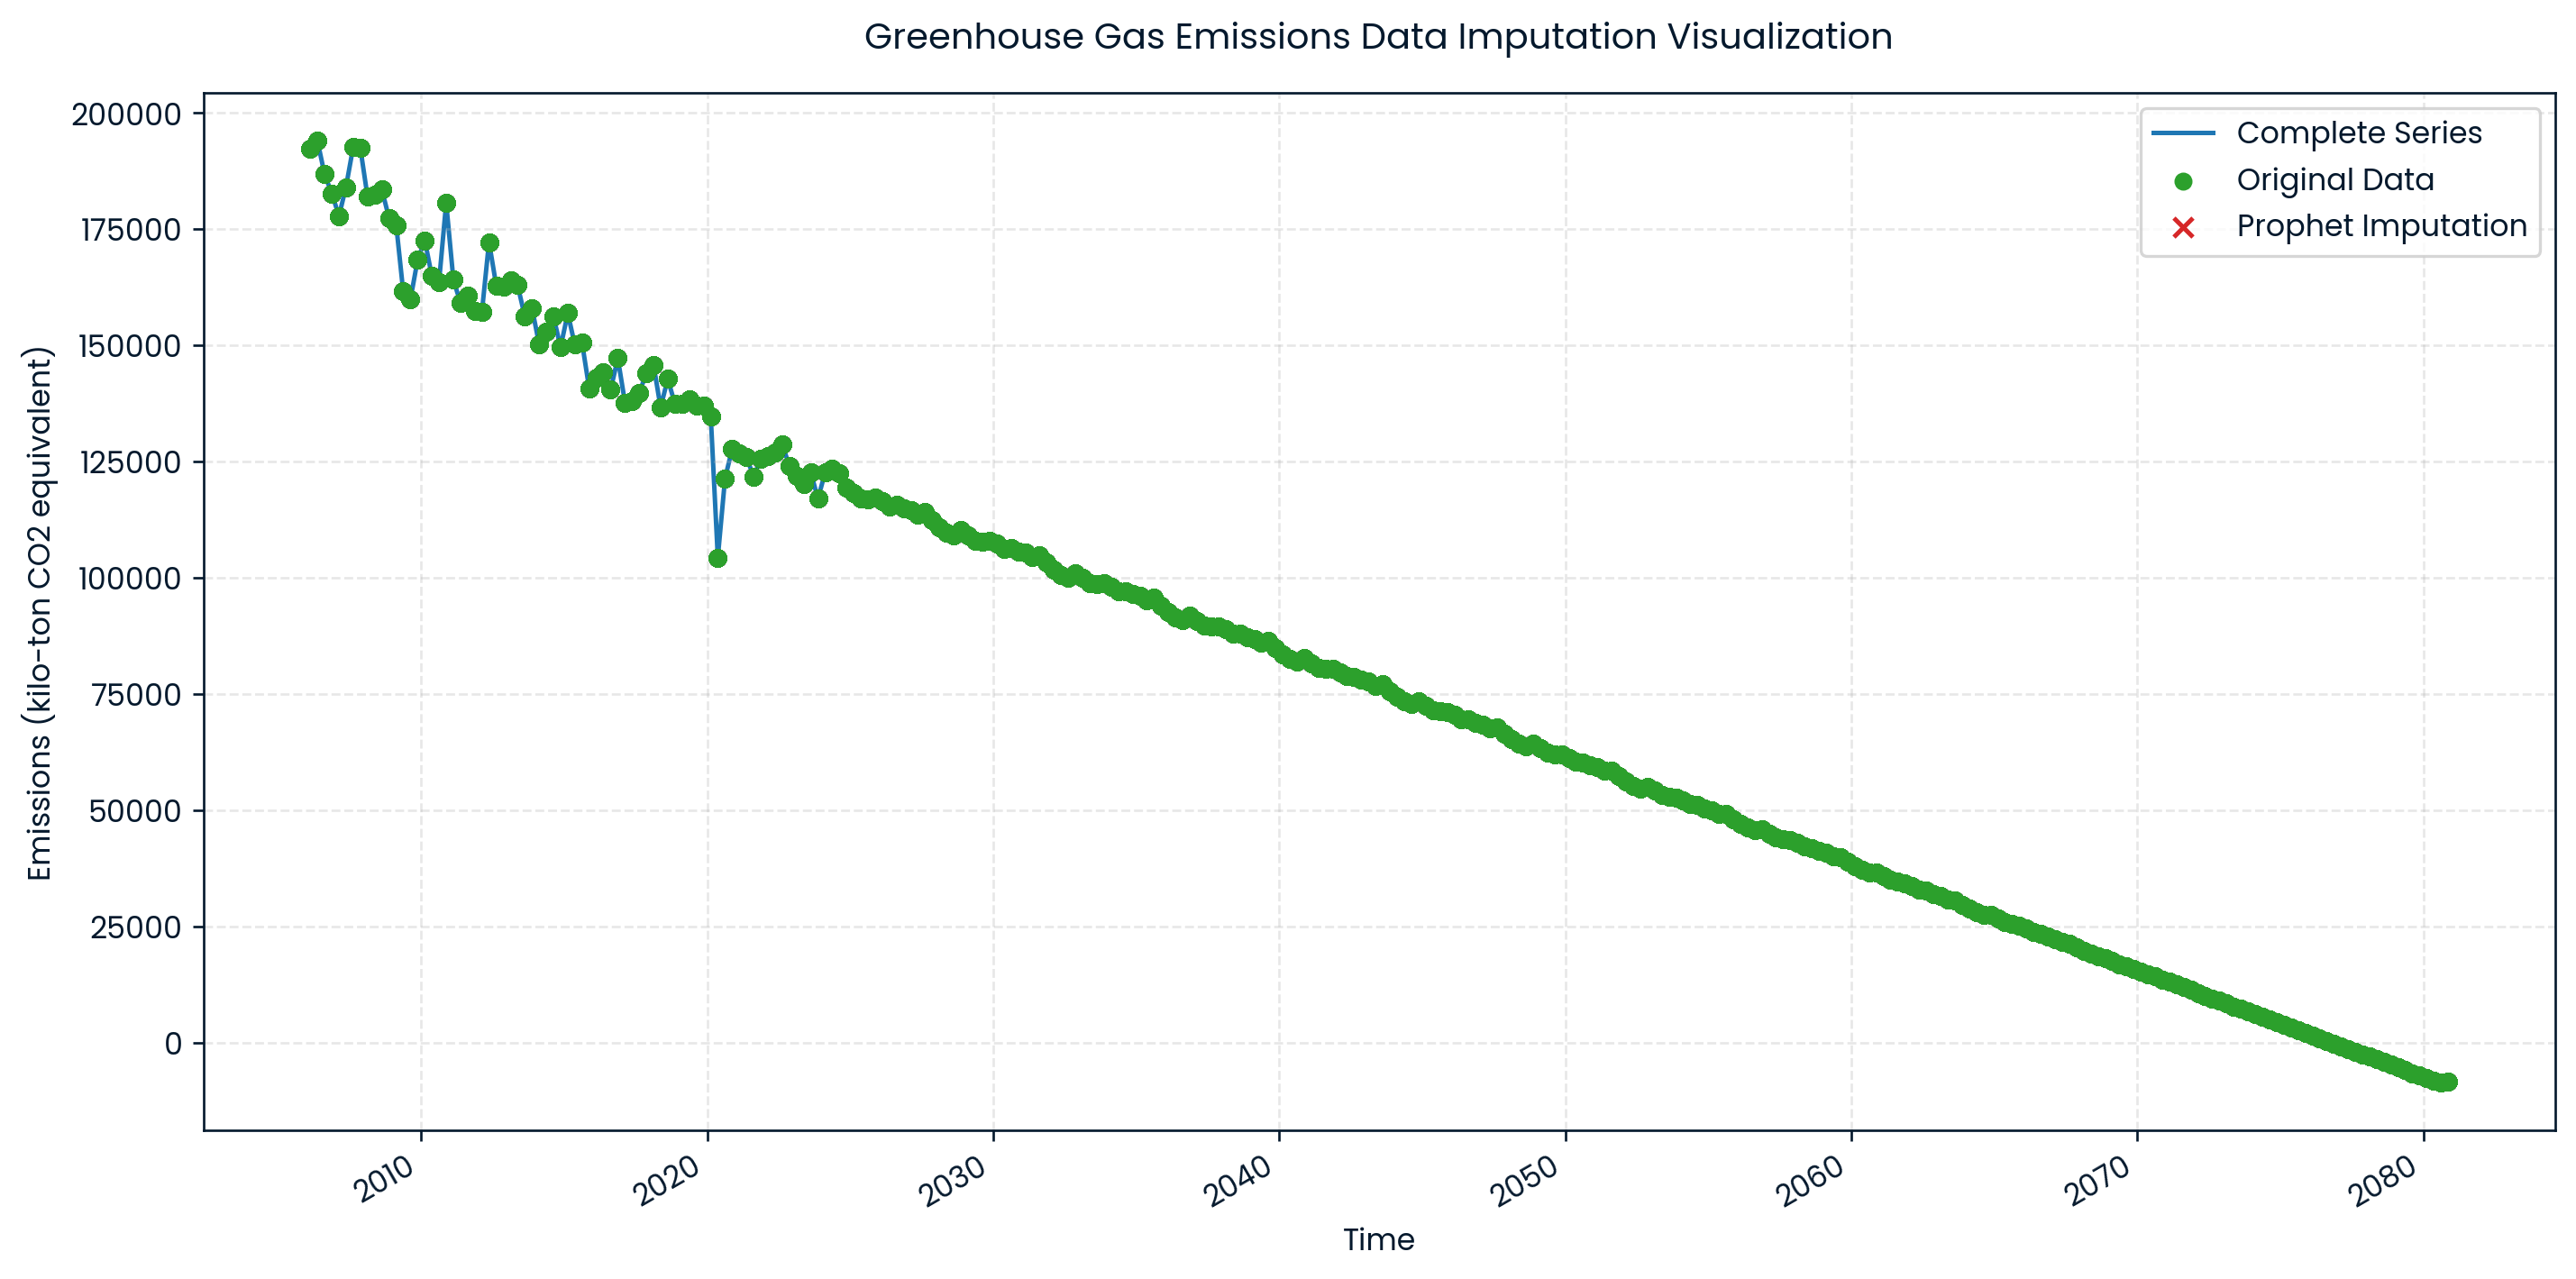

In [10]:
# Corrected timestamp generation code
timestamps = df_merged.apply(
    lambda row: pd.Timestamp(
        year=int(row['Year']),
        month=3 * int(row['Quarter']) -1,  # Corrected quarter-to-month conversion
        day=15
    ), 
    axis=1
)

# Complete visualization code (revised version)
import matplotlib.pyplot as plt

# Generate correct time labels (mid-quarter months: Feb, May, Aug, Nov)
timestamps = df_merged.apply(
    lambda row: pd.Timestamp(
        year=int(row['Year']),
        month=3 * int(row['Quarter']) - 1,  # Q1->Feb(3*1-1=2), Q2->May(3*2-1=5)
        day=15
    ),
    axis=1
)

# Create visualization DataFrame
viz_df = pd.DataFrame({
    'Time': timestamps,
    'Original': df_merged['SA_Emissions'],
    'Imputed_Mask': df_merged['SA_Emissions'].isnull()  # Flag imputation points
})

# Configure plot style
plt.figure(figsize=(12, 6), dpi=120)
plt.rcParams['font.size'] = 10

# Plot main series
main_plot = plt.plot(
    viz_df['Time'], 
    viz_df['Original'],
    color='#1f77b4',
    linewidth=1.5,
    label='Complete Series',
    zorder=1
)

# Mark original data points
original_points = plt.scatter(
    viz_df.loc[~viz_df['Imputed_Mask'], 'Time'],
    viz_df.loc[~viz_df['Imputed_Mask'], 'Original'],
    color='#2ca02c',
    s=25,
    label='Original Data',
    zorder=2
)

# Mark imputed data points
imputed_points = plt.scatter(
    viz_df.loc[viz_df['Imputed_Mask'], 'Time'],
    viz_df.loc[viz_df['Imputed_Mask'], 'Original'],
    color='#d62728',
    marker='x',
    s=40,
    linewidth=1.5,
    label='Prophet Imputation',
    zorder=3
)

# Add annotations and labels
plt.title('Greenhouse Gas Emissions Data Imputation Visualization', pad=15)
plt.xlabel('Time')
plt.ylabel('Emissions (kilo-ton CO2 equivalent)')
plt.grid(alpha=0.3, linestyle='--')
plt.legend()

# Auto-format time axis
plt.gcf().autofmt_xdate()

# Save and display
plt.tight_layout()
plt.savefig('prophet_filling_visualization.png', bbox_inches='tight')
plt.show()

In [11]:
ds

<xarray.Dataset> Size: 65MB
Dimensions:       (time: 27374, lat: 11, lon: 6)
Coordinates:
  * lat           (lat) float32 44B 49.48 50.42 51.36 52.3 ... 57.02 57.96 58.9
  * lon           (lon) float32 24B 352.5 353.8 355.0 356.2 357.5 358.8
  * time          (time) object 219kB 2006-01-02 00:00:00 ... 2080-12-31 00:0...
Data variables:
    TREFMXAV_U    (time, lat, lon) float32 7MB ...
    FLNS          (time, lat, lon) float32 7MB ...
    FSNS          (time, lat, lon) float32 7MB ...
    PRECT         (time, lat, lon) float32 7MB ...
    PRSN          (time, lat, lon) float32 7MB ...
    QBOT          (time, lat, lon) float32 7MB ...
    TREFHT        (time, lat, lon) float32 7MB ...
    UBOT          (time, lat, lon) float32 7MB ...
    VBOT          (time, lat, lon) float32 7MB ...
    SA_Emissions  (time) float32 109kB 1.922e+05 1.922e+05 ... -8.361e+03